In [1]:
import pandas as pd
import numpy as np
from math import pow
from scipy import integrate
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [3]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude
def ft_to_meters(ft): return ft * 0.3048

In [4]:
boost_end = 3_500
first_charge = 28_125

In [5]:
altim = df[['pressure (kPa)']].copy()

In [6]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

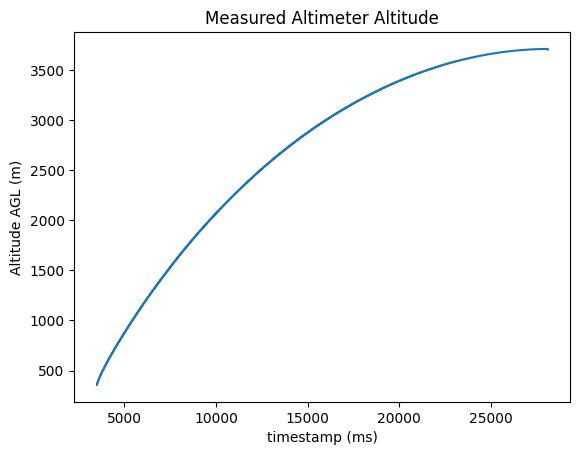

In [7]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

In [8]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

In [9]:
nice_data['t'] = nice_data.index

In [10]:
actual_apogee, actual_apogee_index = nice_data['alt_m_agl'].max(), nice_data['alt_m_agl'].argmax() 
actual_apogee_time = nice_data.iloc[actual_apogee_index].t
print(actual_apogee, actual_apogee_time)

3712.8837039159207 28.056


In [11]:
def curve_fit_to_now(row, window_size_sec = 1):
    endt = row.name
    startt = max(endt - window_size_sec, nice_data.iloc[0].name)
    data = nice_data[startt:endt]

    poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = np.poly1d(poly)
    outs = predictor(nice_data.index)
    predicted_apogee, predicted_apogee_index = outs.max(), outs.argmax()
    predicted_apogee_time = nice_data.iloc[predicted_apogee_index].name

    if predicted_apogee > 10_000:
        predicted_apogee = 10_000
    elif predicted_apogee < 0:
        return 0
    pred_alt = predictor(endt)
    return pred_alt, predicted_apogee, predicted_apogee_time, poly[0], poly[1], poly[2]

In [12]:
window_sizes = [0.25, 0.375, 0.5, 1, 2,5 , 8, 10, 15, 20, 30]

In [13]:
datas = []
for win_size in window_sizes:
    data = nice_data.apply(lambda row : curve_fit_to_now(row, win_size), axis=1, result_type='expand')\
        .rename(columns = {0:'pred_alt', 1:'pred_apogee', 2:'pred_apogee_t', 3:'e0', 4:'e1', 5:'e2'})

    data['apogee_diff'] = actual_apogee - data['pred_apogee']
    data['apogee_diff_t'] = actual_apogee_time - data['pred_apogee_t']
    data['alt_diff'] = nice_data['alt_m_agl'] - data['pred_alt']

    datas.append(data)

/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/619498545.py:6: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_387137/61949

/tmp/ipykernel_387137/1053598369.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


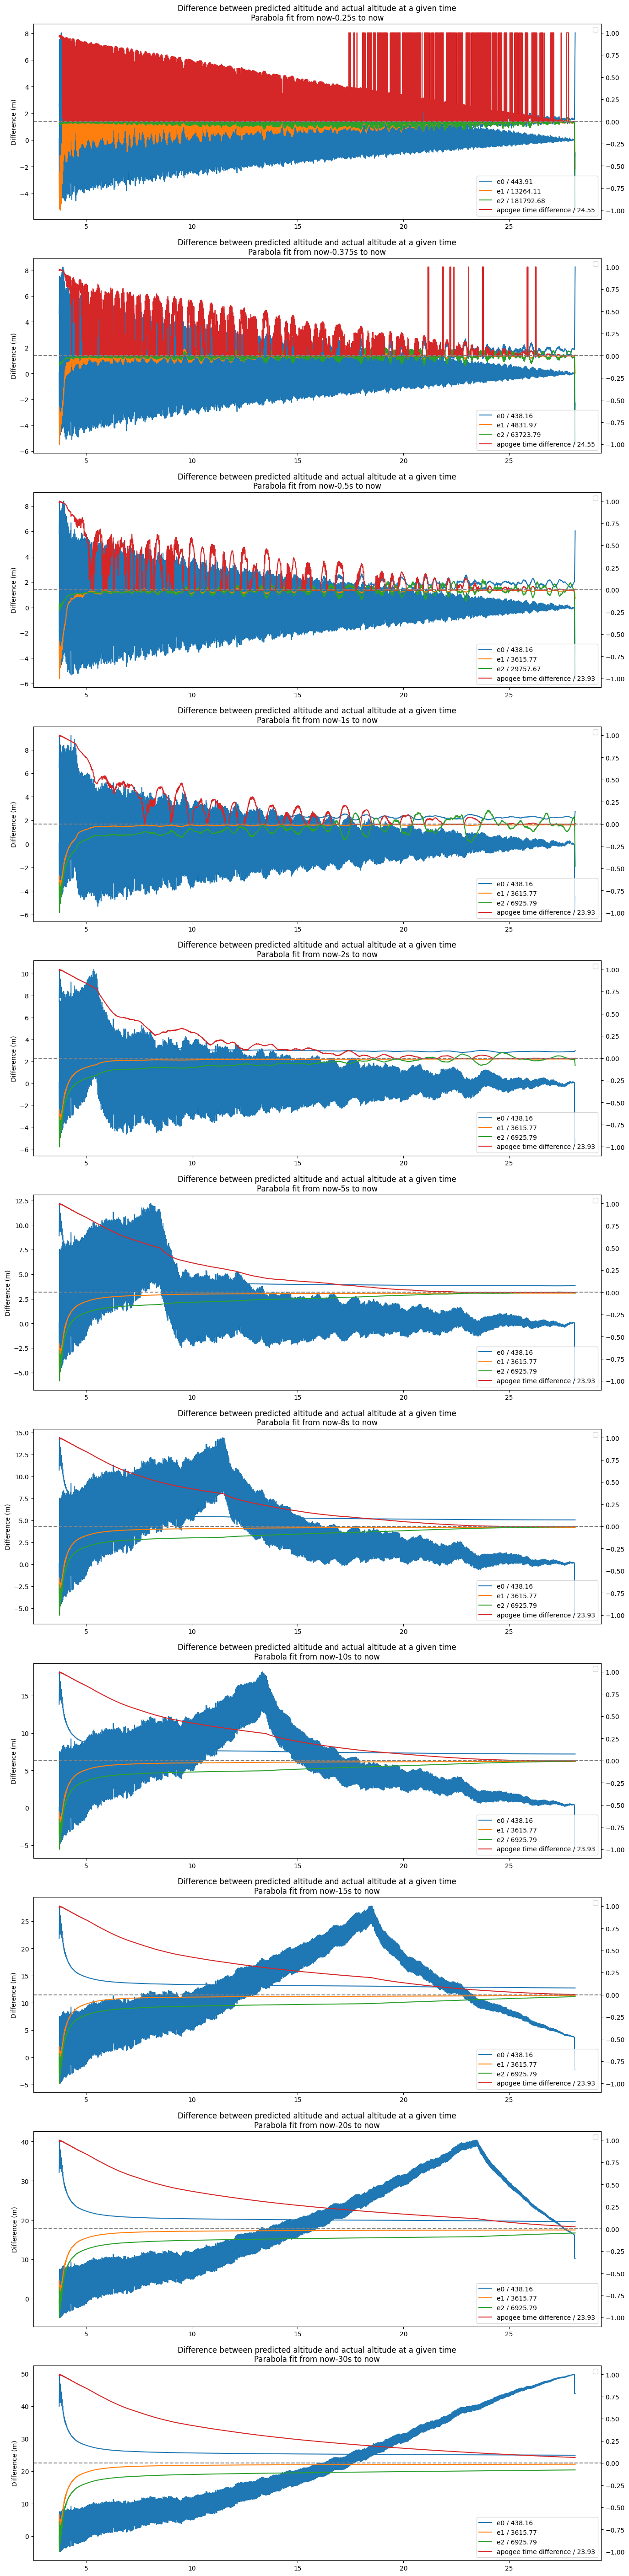

In [14]:
for i, (win_size, data) in enumerate(zip(window_sizes, datas)):
    wdata = data.iloc[60:]

    me0 = wdata['e0'].abs().max()
    me1 = wdata['e1'].abs().max()
    me2 = wdata['e2'].abs().max()

    fig = plt.subplot(len(window_sizes), 1, i+1)

    fig.plot(wdata['alt_diff'])
    tx = fig.twinx()
    tx.plot(wdata['e1'] / me1, label = f"e0 / {me0:.2f}")
    tx.plot(wdata['e0'] / me0, label = f"e1 / {me1:.2f}")
    tx.plot(wdata['e2'] / me2, label = f"e2 / {me2:.2f}")


    madt = wdata['apogee_diff_t'].abs().max()
    tx.plot(wdata['apogee_diff_t'] / madt, label = f"apogee time difference / {madt:.2f}")


    tx.axhline(0, c = 'gray', linestyle = 'dashed')

    fig.set_title(f"Difference between predicted altitude and actual altitude at a given time\nParabola fit from now-{win_size}s to now")
    fig.set_ylabel("Difference (m)")
    fig.legend()
    tx.legend(loc = 'lower right')

fig.get_figure().set_figwidth(16)
fig.get_figure().set_figheight(9*8)


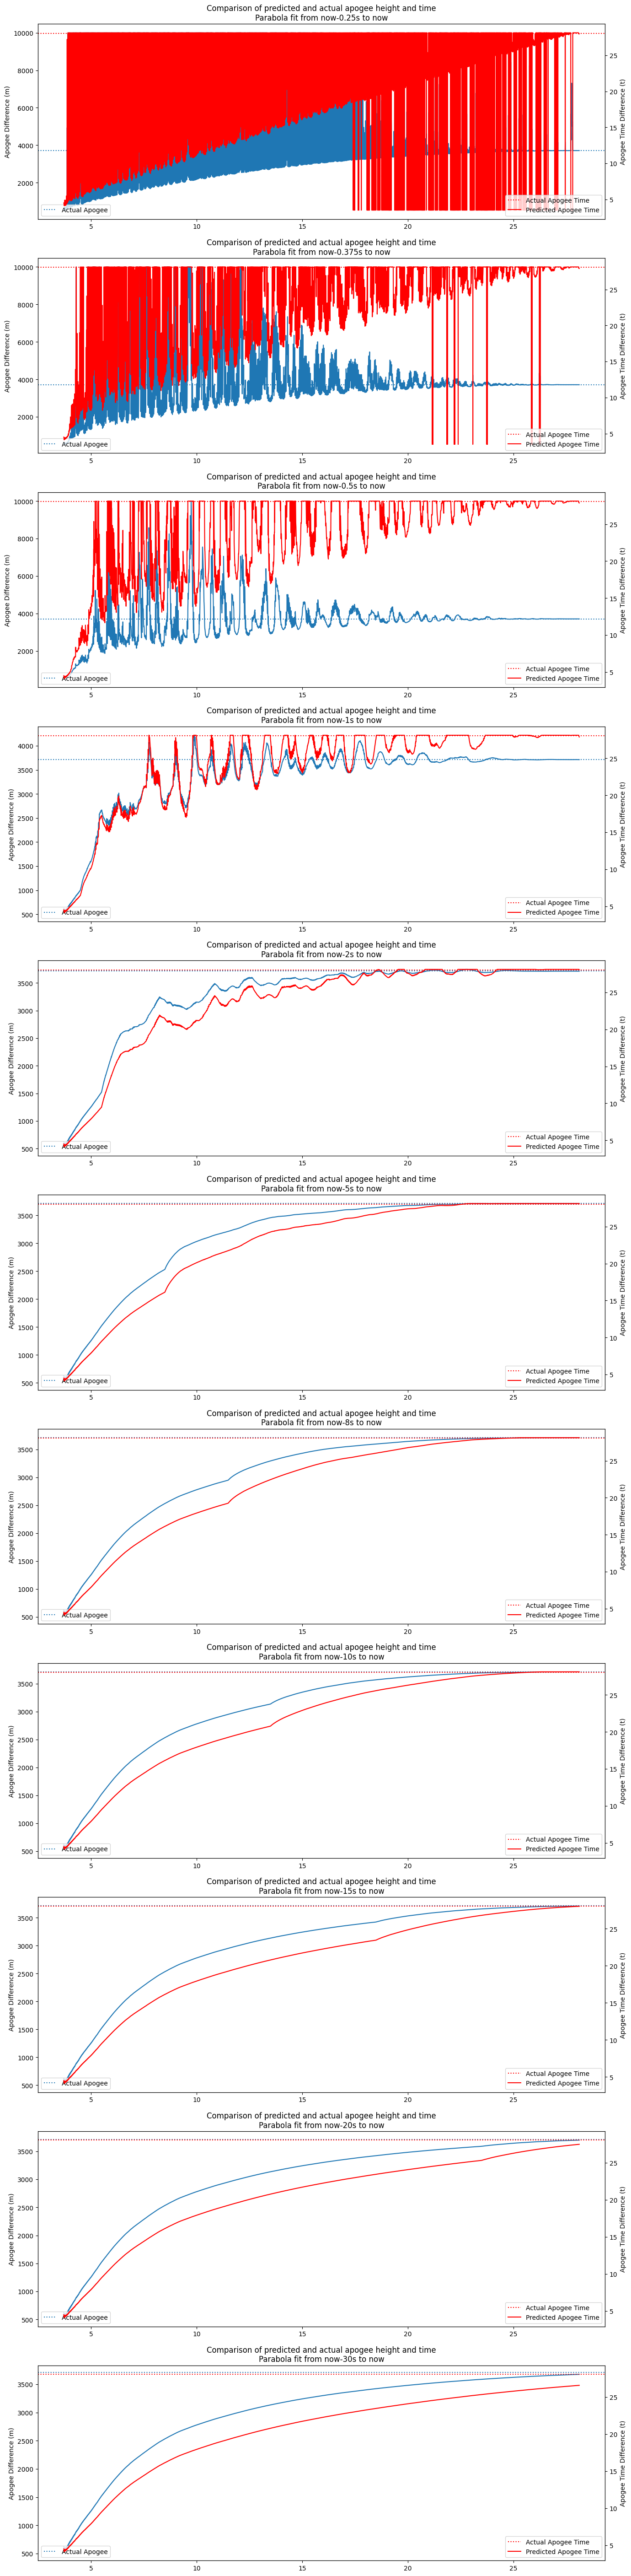

In [15]:
for i, (win_size, data) in enumerate(zip(window_sizes, datas)):
    wdata = data.iloc[60:]

    p = plt.subplot(len(window_sizes), 1, i+1)
    p.plot(wdata['pred_apogee'])
    p.axhline(actual_apogee, linestyle='dotted', label = 'Actual Apogee')
    p.legend(loc = 'lower left')

    tx = p.twinx()
    tx.axhline(actual_apogee_time, linestyle='dotted', c = 'red', label = "Actual Apogee Time")
    tx.plot(wdata['pred_apogee_t'], c = 'red', label = 'Predicted Apogee Time')

    tx.legend(loc = 'lower right')
    p.set_title(f"Comparison of predicted and actual apogee height and time\nParabola fit from now-{win_size}s to now")
    p.set_ylabel("Apogee Difference (m)")
    tx.set_ylabel("Apogee Time Difference (t)");
p.get_figure().set_figwidth(16)
p.get_figure().set_figheight(9*8)

Measuring model performance
integral of error over time
if we're accurate the whole time, we'll have a smaller number

if were bad for half but good for the other, medium number

if were bad the whole time, big number

we want the littlest score

In [16]:
rows = []
for i, (win_size, data) in enumerate(zip(window_sizes, datas)):
    wdata = data.iloc[60:]
    apogee_score = integrate.trapezoid(wdata.apogee_diff, wdata.index)
    apogee_time_score = integrate.trapezoid(wdata.apogee_diff_t, wdata.index)
    rows.append((win_size, apogee_score, apogee_time_score))

res_df = pd.DataFrame.from_records(rows, columns=["Window Size", "Apogee Score", "Apogee Time Score"]).set_index("Window Size")

In [17]:
res_df

,Apogee Score,Apogee Time Score
Window Size,,
0.250,-28063.692156,178.238739
0.375,-4331.492532,105.981505
0.500,3278.538876,100.212665
1.000,8566.157509,96.415143
2.000,10546.283952,106.685370
5.000,13402.829604,131.891504
8.000,14960.576563,149.199523
10.000,15655.492958,158.100607
15.000,16688.615182,174.186644


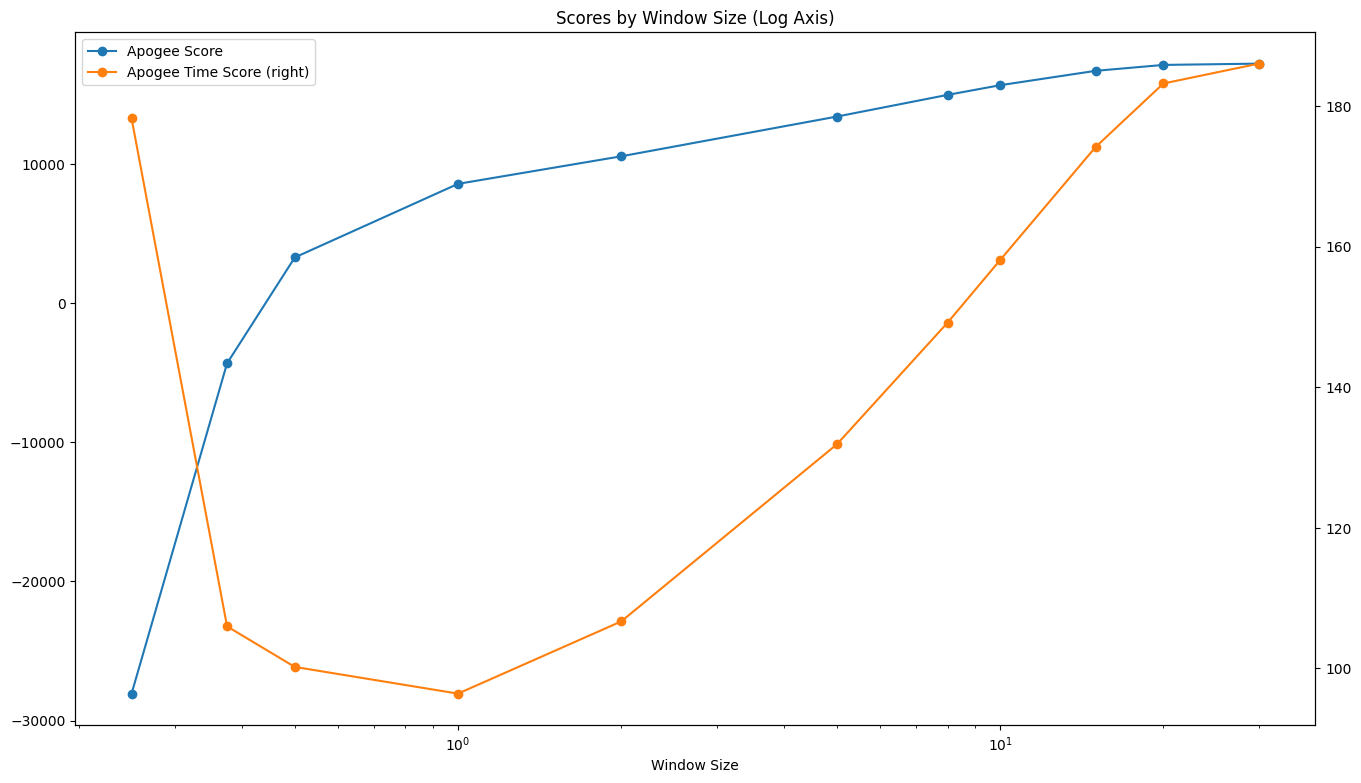

In [18]:
p = res_df.plot(secondary_y="Apogee Time Score", logx=True, figsize=(16,9), marker = 'o')
p.set_title("Scores by Window Size (Log Axis)");

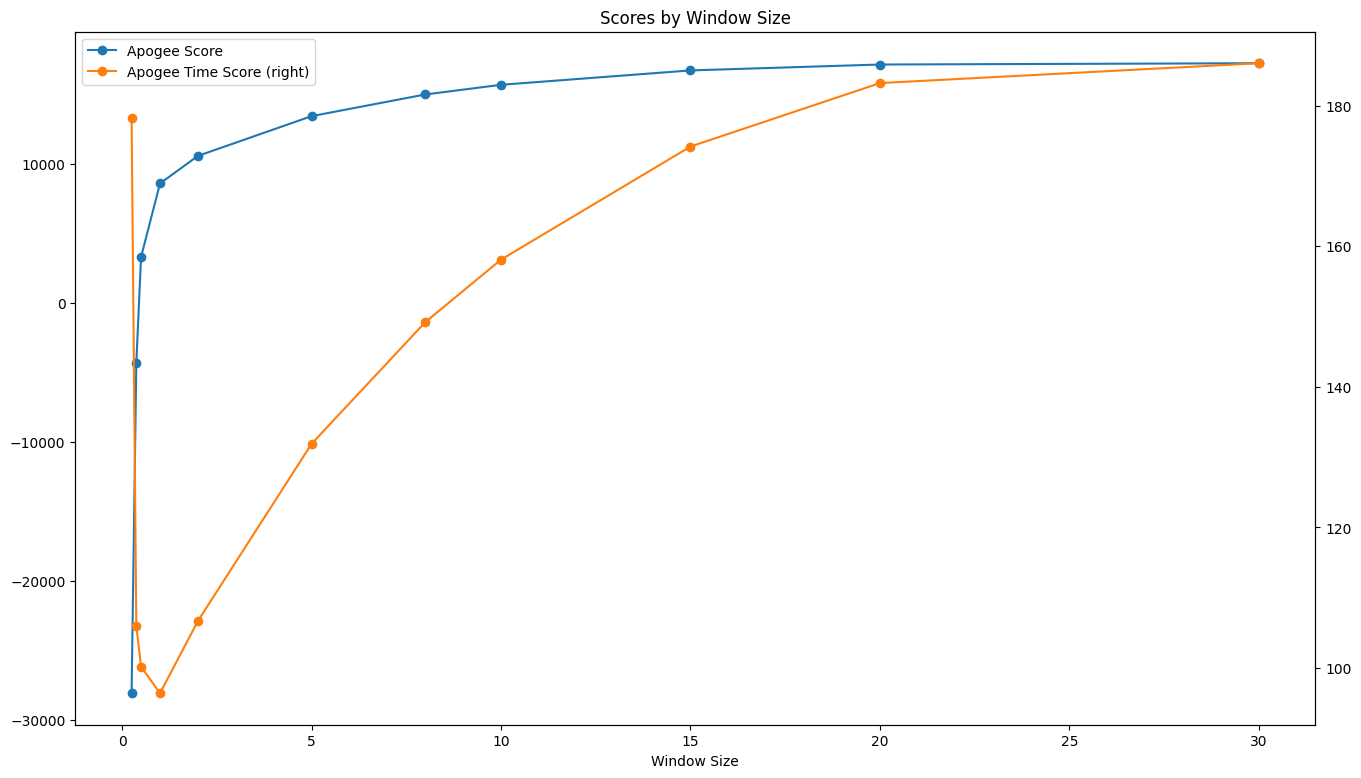

In [19]:
p = res_df.plot(secondary_y="Apogee Time Score", logx=False, figsize=(16,9), marker = 'o')
p.set_title("Scores by Window Size");